In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

from pyCGM2.Tools import btkTools
from pyCGM2.ForcePlates import forceplates

from SOLE.FeetMe import FeetMe
from Walking.Walking import Walking
from Tools.ToolsFFT import TransformFourrier


DataPath = 'C:\\Users\\Nathan\\Desktop\\Wheelchair tests datas\\grf\\'
Path = DataPath + 'gait_test4.c3d'

acq = btkTools.smartReader(Path)
grwc = btkTools.getForcePlateWrench(acq)
mass = 60 # en kg

forces = []
items = [0,1]
for it in items:
    forces.append(grwc.GetItem(it).GetForce().GetValues() / (mass * 9.81) * 100)

dataLeft = pd.DataFrame()
    # VerticalGrfLeft
dataLeft["VerticalVGrf"] = TransformFourrier(forces[1][:,2], seuil=10000) 
dataLeft["VerticalVGrf"][dataLeft["VerticalVGrf"] < 10] = 0
    # ApGrfLeft
dataLeft["ApGrf"] = TransformFourrier(forces[1][:,1], seuil=5000)
#MediolateralGrfLeft  !!! ici on multiplie par -1 pour repasser dans le bon sens l'axe de la plateforme
dataLeft["MediolateralGrf"] = TransformFourrier(forces[1][:,0] * -1, seuil=1300)



SoleInstanceLeft = FeetMe(1000)
SoleInstanceLeft.SetGroundReactionForce("Vertical", dataLeft["VerticalVGrf"].to_numpy())
SoleInstanceLeft.SetGroundReactionForce("Ap", dataLeft["ApGrf"].to_numpy())
SoleInstanceLeft.SetGroundReactionForce("Mediolateral", dataLeft["MediolateralGrf"].to_numpy())
SoleInstanceLeft.constructTimeseries()


dataRight = pd.DataFrame()
    # VerticalGrfLeft
dataRight["VerticalVGrf"] = TransformFourrier(forces[0][:,2], seuil=10000) 
dataRight["VerticalVGrf"][dataRight["VerticalVGrf"] < 10] = 0
    # ApGrfLeft
dataRight["ApGrf"] = TransformFourrier(forces[0][:,1], seuil=5000)
#MediolateralGrfLeft  
dataRight["MediolateralGrf"] = TransformFourrier(forces[0][:,0], seuil=1300)

SoleInstanceRight = FeetMe(1000)
SoleInstanceRight.SetGroundReactionForce("Vertical", dataRight["VerticalVGrf"].to_numpy())
SoleInstanceRight.SetGroundReactionForce("Ap", dataRight["ApGrf"].to_numpy())
SoleInstanceRight.SetGroundReactionForce("Mediolateral", dataRight["MediolateralGrf"].to_numpy())
SoleInstanceRight.constructTimeseries()

walking = Walking(mass)
walking.setLeftLegSole(SoleInstanceLeft)
walking.setRightLegSole(SoleInstanceRight)

2023-05-10 20:52:01,003 - [ERROR] - pyCGM2 - (__init__.py).<module>(63) - EMG_CHANNELS is empty 


In [ ]:
from Walking.WalkingFilters import WalkingKinematicsFilter
from Walking.WalkingKinematicsProcedure import GroundReactionForceKinematicsProcedure

procedure = GroundReactionForceKinematicsProcedure()
WalkingKinematicsFilter(walking, procedure).run()

Normalisation des forces de réactions au sol de chaque pas en % de cycle et en % de poids du corps

In [ ]:
from Walking.WalkingFilters import WalkingDataProcessingFilter
from Walking.WalkingDataProcessingProcedure import NormalisationProcedure

procedure = NormalisationProcedure()
WalkingDataProcessingFilter(walking, procedure).run()

#du coup je relance les calculs des valeurs sur les donnés normalisés
procedure = GroundReactionForceKinematicsProcedure()
WalkingKinematicsFilter(walking, procedure).run()

Visualisation des datas trouvés par la procédure GroundReactionForceKinematicsProcedure() sur les GRF correspondantes :

In [ ]:
for stepindex in [0,1,2,3,4] :
# for stepindex in np.arange(len(walking.m_StepGrfValue['LeftLeg']['VerticalGrf']) - 1) : # plot tout les pas avec les data trouvés
    """ Visualisation des valeurs retrouvées par GroundReactionForceKinematicsProcedure() """
    FrameRate = 10
    step = stepindex
    print(f"Pas numéro {step}")

    """ Vertical Ground Reaction Force Data """ 

    FirstPeak = walking.m_GroundReactionForces["LeftLeg"][step][0]
    MidstanceValley = walking.m_GroundReactionForces["LeftLeg"][step][1]
    SecondPeak = walking.m_GroundReactionForces["LeftLeg"][step][2]
    FirtPeakTimeTo = walking.m_GroundReactionForces["LeftLeg"][step][3] * FrameRate
    MidstanceValleyTimeTo = walking.m_GroundReactionForces["LeftLeg"][step][4] * FrameRate
    SecondPeakTimeTo = walking.m_GroundReactionForces["LeftLeg"][step][5] * FrameRate
    TimeFromMidstanceValleyToToeOff = walking.m_GroundReactionForces["LeftLeg"][step][6] * FrameRate

    plt.plot(walking.m_StepGrfValue['LeftLeg']['VerticalGrf'][step])
    plt.scatter(x=FirtPeakTimeTo ,y=FirstPeak, c ="r", label="FirstPeak")
    plt.scatter(x=SecondPeakTimeTo ,y=SecondPeak, c="g", label="SecondPeak")
    plt.scatter(x=MidstanceValleyTimeTo ,y=MidstanceValley, c="b", label="MidstanceValley")
    plt.hlines(y=MidstanceValley, xmin=MidstanceValleyTimeTo, xmax=TimeFromMidstanceValleyToToeOff+MidstanceValleyTimeTo,
            colors ="r", ls="--", label='TimeFromMidstanceValleyToToeOff')
    plt.legend()
    plt.show()


    """ Ant-Post Ground Reaction Force Data """
    BrakingPeak = walking.m_GroundReactionForces["LeftLeg"][step][10]
    PropulsivePeak = walking.m_GroundReactionForces["LeftLeg"][step][11]
    BrakePhaseDuration = walking.m_GroundReactionForces["LeftLeg"][step][12] * FrameRate
    PropulsivePhaseDuration = walking.m_GroundReactionForces["LeftLeg"][step][13] * FrameRate
    BrakePhaseTimeTo = walking.m_GroundReactionForces["LeftLeg"][step][14] * FrameRate
    PropulsivePhaseTimeTo = walking.m_GroundReactionForces["LeftLeg"][step][15] * FrameRate

    plt.plot(walking.m_StepGrfValue['LeftLeg']['ApGrf'][step])
    plt.scatter(x= BrakePhaseTimeTo, y=BrakingPeak, c="r", label='BrakingPeak')
    plt.scatter(x= PropulsivePhaseTimeTo + BrakePhaseDuration, y=PropulsivePeak, c="g", label='PropulsivePeak')
    plt.hlines(y=0, xmin=0, xmax=102, colors ="black", ls="--")
    plt.hlines(y=0, xmin=0, xmax=BrakePhaseDuration, colors ="r", ls="--", label='BrakePhaseDuration')
    plt.hlines(y=0, xmin=BrakePhaseDuration, xmax=BrakePhaseDuration + PropulsivePhaseDuration, colors ="g", ls="--", label='PropulsivePhaseDuration')
    plt.legend()
    plt.show()

Montre les pas les plus et les moins asymétriques pour chaques paramètres de la marche

In [ ]:
from Walking.WalkingFilters import WalkingKinematicsFilter
from Walking.WalkingKinematicsProcedure import DynamicSymetryFunctionComputeProcedure
from Walking.WalkingGraphicsProcedure import PlotMaxAndMinAsymetryProcedure
from Walking.WalkingFilters import WalkingGraphicsFilter

procedure = DynamicSymetryFunctionComputeProcedure()
WalkingKinematicsFilter(walking, procedure).run()
procedure = PlotMaxAndMinAsymetryProcedure()
WalkingGraphicsFilter(walking, procedure).run()

Cherche les pas les plus et moins asymétriques pour l'ensemble des paramètres

In [ ]:
from Walking.WalkingFilters import WalkingDataProcessingFilter, WalkingKinematicsFilter
from Walking.WalkingDataProcessingProcedure import NormalisationProcedure
from Walking.WalkingKinematicsProcedure import DynamicSymetryFunctionComputeProcedure
from Walking.WalkingGraphicsProcedure import PlotWorthAndBestStepProcedure

procedure = NormalisationProcedure()
WalkingDataProcessingFilter(walking, procedure).run()
procedure = GroundReactionForceKinematicsProcedure()
WalkingKinematicsFilter(walking, procedure).run()
procedure = DynamicSymetryFunctionComputeProcedure()
WalkingKinematicsFilter(walking, procedure).run()
procedure = PlotWorthAndBestStepProcedure()
WalkingGraphicsFilter(walking, procedure).run()

In [ ]:
from Walking.WalkingFilters import WalkingDataProcessingFilter
from Walking.WalkingDataProcessingProcedure import CutDataProcessingProcedure

procedure = CutDataProcessingProcedure()
procedure.setCutNumber(n_cut=3)
WalkingDataProcessingFilter(walking, procedure).run()

from Walking.WalkingFilters import WalkingGraphicsFilter
from Walking.WalkingGraphicsProcedure import PlotCutGroundReactionForceProcedure

procedure = PlotCutGroundReactionForceProcedure()
WalkingGraphicsFilter(walking, procedure).run()

In [ ]:
from Walking.WalkingFilters import WalkingKinematicsFilter, WalkingGraphicsFilter
from Walking.WalkingKinematicsProcedure import TwoStepProcedure
from Walking.WalkingGraphicsProcedure import PlotTwoStepProcedure

procedure = TwoStepProcedure()
WalkingKinematicsFilter(walking, procedure).run()

procedure = PlotTwoStepProcedure()
WalkingGraphicsFilter(walking, procedure).run()

Représenter l'asymétrie d'un pas moyen droit par rapport au gauche dans les trois axes PlotDynamicSymetryFunctionNormalised 

GroundReactionForceKinematicsProcedure : done
NormalisationProcedure : done


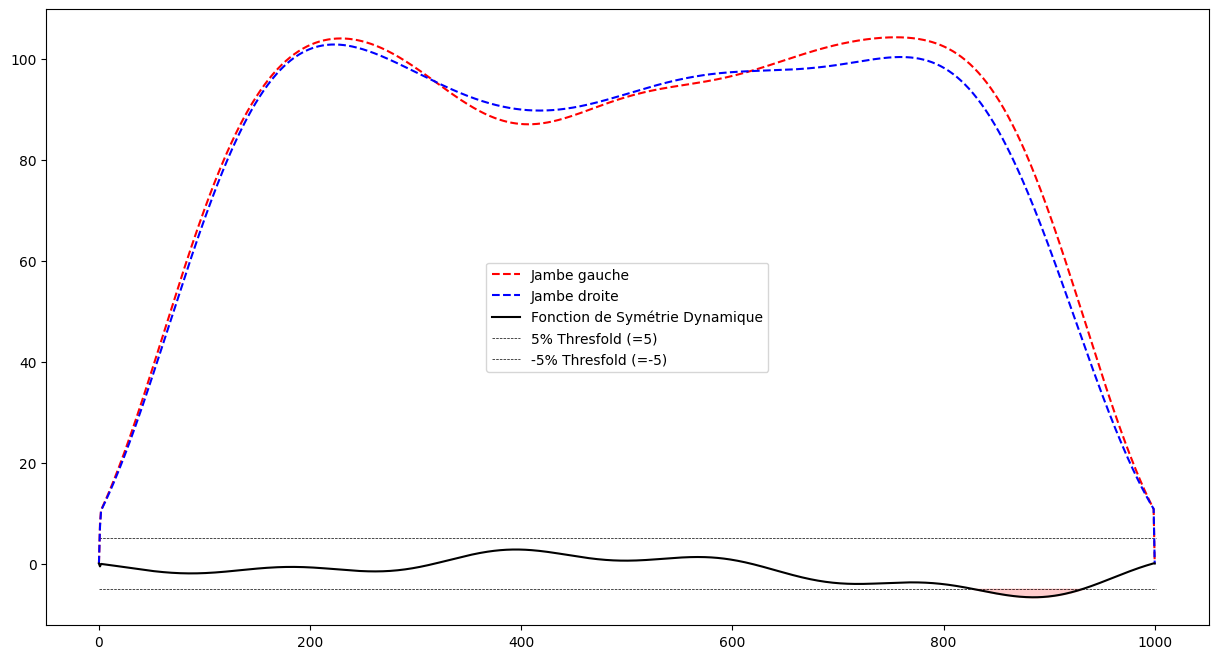

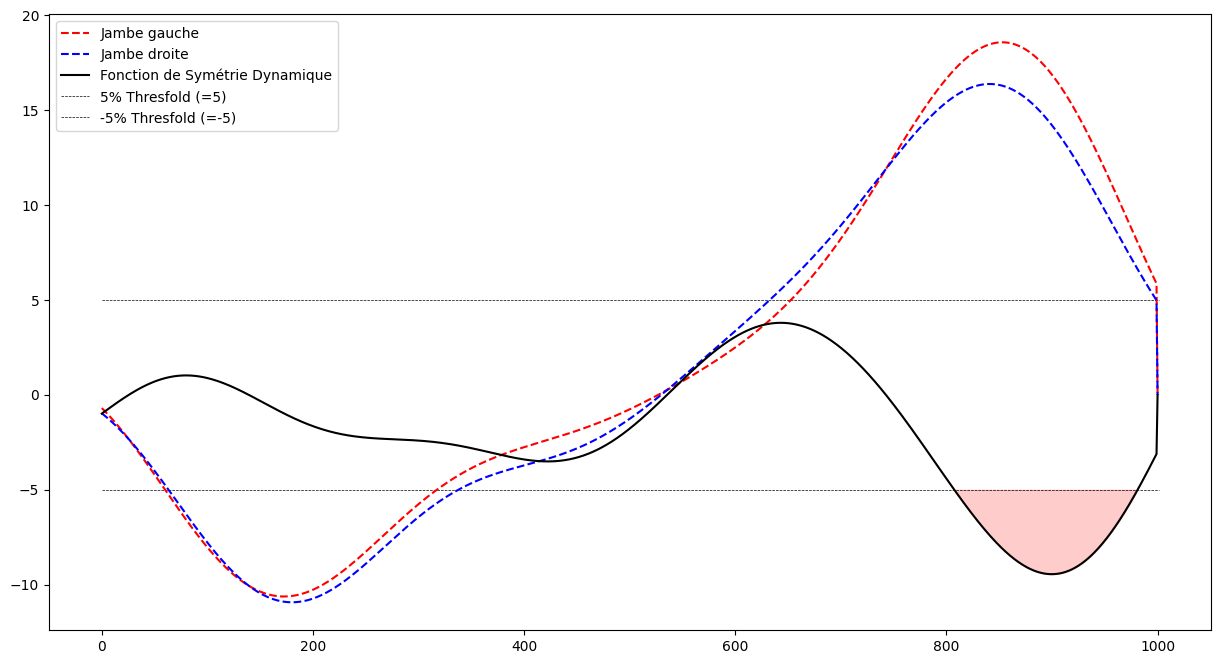

In [2]:
from Walking.WalkingFilters import WalkingGraphicsFilter
from Walking.WalkingGraphicsProcedure import PlotDynamicSymetryFunctionNormalisedProcedure

procedure = PlotDynamicSymetryFunctionNormalisedProcedure()
WalkingGraphicsFilter(walking, procedure).run()